In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chart_studio.plotly as plotly
from collections import defaultdict
import re
from matplotlib.dates import date2num, num2date
import warnings
warnings.filterwarnings('ignore')

Number of valid repositories: 3109
Number of repositories that has release note: 72.79%


In [ ]:
num_valid_repos = 3109
print("Number of valid repositories:", num_valid_repos)
repos = pd.read_csv("statistic/has_release.csv")
print("Number of repositories that has release note:", f"{round(len(repos) / num_valid_repos * 10000) / 100}%")

create_year
2008    Axes(0.125,0.11;0.775x0.77)
2009    Axes(0.125,0.11;0.775x0.77)
2010    Axes(0.125,0.11;0.775x0.77)
2011    Axes(0.125,0.11;0.775x0.77)
2012    Axes(0.125,0.11;0.775x0.77)
2013    Axes(0.125,0.11;0.775x0.77)
2014    Axes(0.125,0.11;0.775x0.77)
2015    Axes(0.125,0.11;0.775x0.77)
2016    Axes(0.125,0.11;0.775x0.77)
2017    Axes(0.125,0.11;0.775x0.77)
2018    Axes(0.125,0.11;0.775x0.77)
2019    Axes(0.125,0.11;0.775x0.77)
2020    Axes(0.125,0.11;0.775x0.77)
2021    Axes(0.125,0.11;0.775x0.77)
2022    Axes(0.125,0.11;0.775x0.77)
2023    Axes(0.125,0.11;0.775x0.77)
Name: create_year, dtype: object

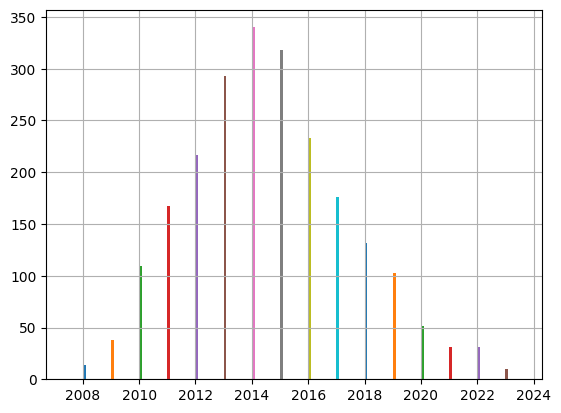

In [34]:
repos["created_at"] = pd.to_datetime(repos["created_at"])
repos["create_year"] = repos["created_at"].dt.year
num_repo_by_year = repos.groupby("create_year")["create_year"]
num_repo_to_year = np.cumsum(num_repo_by_year.count().to_numpy())
year = np.arange(2008, 2024, 1)
fig = plt.figure()
axes = fig.add_axes([0, 0, 0.6, 0.6])
axes.bar(year, num_repo_to_year)
axes.set_xlabel("Year")
axes.set_ylabel("Num repo")
axes.set_title("Total repositories to year")
fig.show()

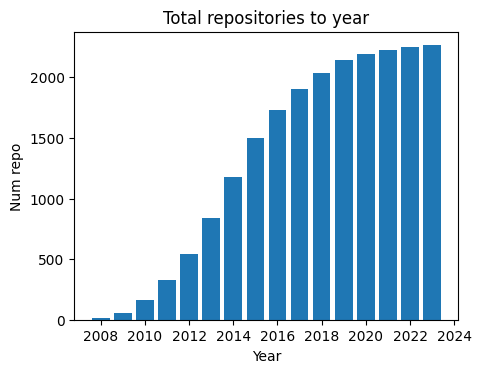

count    2263.000000
mean       71.451171
std       184.258744
min         1.000000
25%        11.000000
50%        30.000000
75%        75.500000
max      5616.000000
Name: num release, dtype: float64
Median: 30.0
Number of repo has less or equal 100 release: 1863


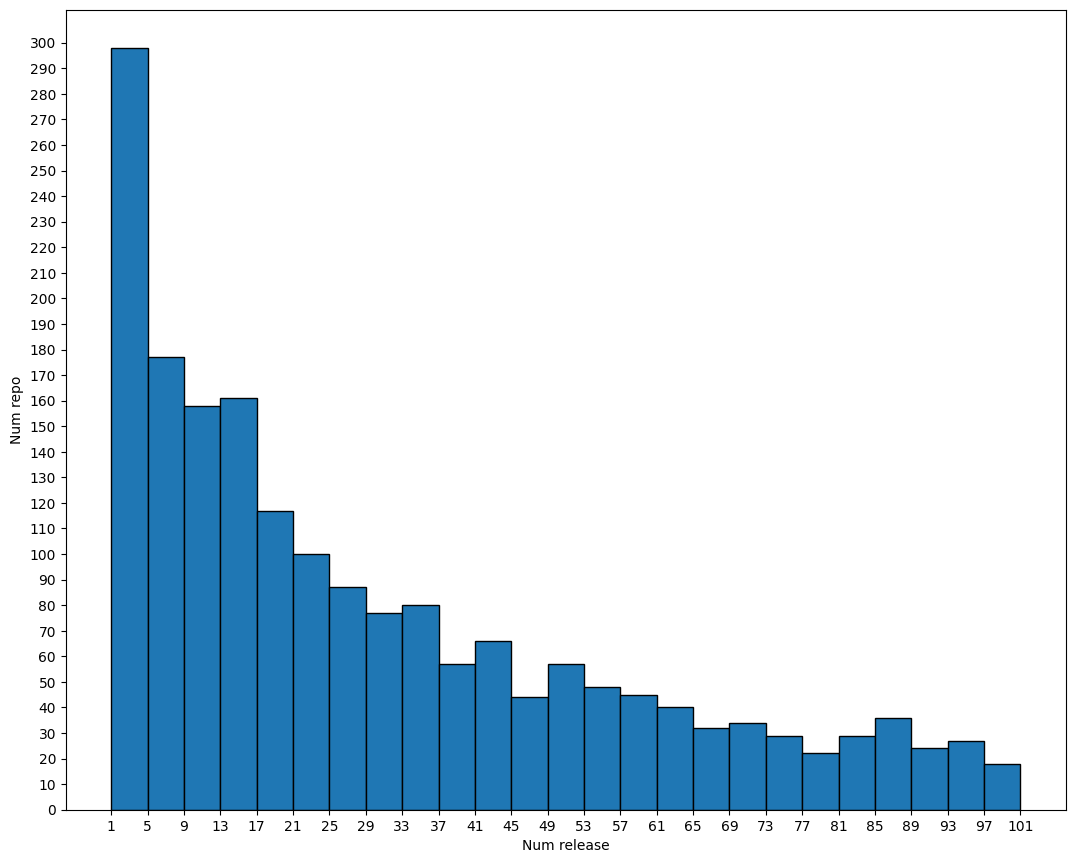

In [36]:

print(repos["num release"].describe())
print("Median:", repos["num release"].median())
num_release = repos["num release"].value_counts()
summa = 0
for idx in range(1, 101):
    summa += num_release[idx]
print('Number of repo has less or equal 100 release:', summa)
x = list(range(1, 102, 4))
counter = defaultdict(int) 
for i in range(len(x) - 1):
    for num in range(x[i], x[i + 1]):
        counter[x[i] + 2] += num_release[num]

fig = plt.figure(figsize=(10, 8))
axes = fig.add_axes([0, 0, 0.6, 0.6])
axes.bar(counter.keys(), counter.values(), 4, edgecolor=(0, 0, 0))
axes.set_xticks([x + 1 for x in range(0, 101, 4)])
axes.set_yticks(np.arange(0, 310, 10))
axes.set_xlabel("Num release")
axes.set_ylabel("Num repo")
fig.show()

In [37]:
# from matplotlib.dates import date2num, num2date
# num_release = 10

# detail = pd.to_datetime(repos[repos["num release"] == num_release]["updated_at"]).dt.to_pydatetime()
# detail = date2num(detail)
# fig = plt.figure()
# axes = fig.add_axes([0, 0, 1, 1])
# axes.boxplot(detail, 0, '')
# # axes.set_yticks(np.arange(10000, 20000, 1000))
# axes.yaxis.set_major_formatter(lambda x, pos: num2date(x).date())
# axes

<Axes: title={'center': 'Time between 2 consecutive release'}>

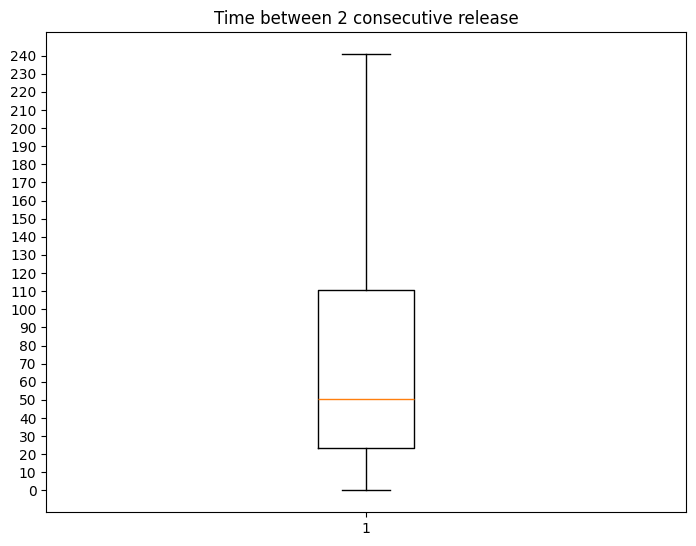

In [38]:
timebw2rn = pd.read_csv("statistic/timebw2rn.csv")["Num days"].to_numpy()

fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.boxplot(timebw2rn, 0, '')
axes.set_yticks(np.arange(0, 250, 10))
axes.set_title("Time between 2 consecutive release")
axes


array([<Axes: >, <Axes: >], dtype=object)

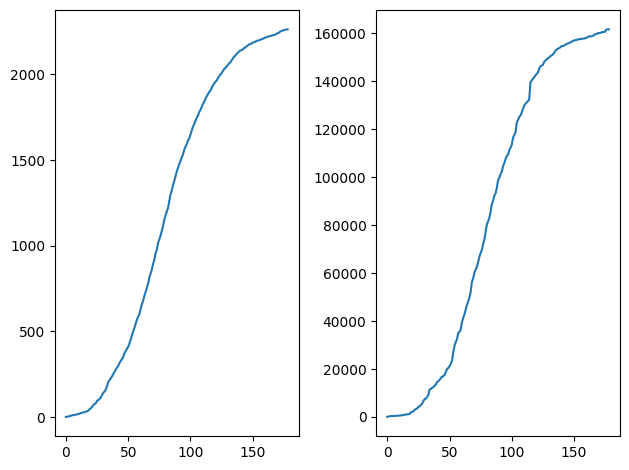

In [39]:

repos["created_at"] = pd.to_datetime(repos["created_at"])
repos["created_month"] = repos["created_at"].dt.month
repos["created_year"] = repos["created_at"].dt.year
num_repo = np.cumsum(repos.groupby(["created_year", "created_month"])["Repo"].count().to_numpy())
num_rn = np.cumsum(repos.groupby(["created_year", "created_month"])["num release"].sum().to_numpy())
x = np.arange(0, len(num_repo),1)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(x, num_repo)
axes[1].plot(x, num_rn)
plt.tight_layout() 

axes

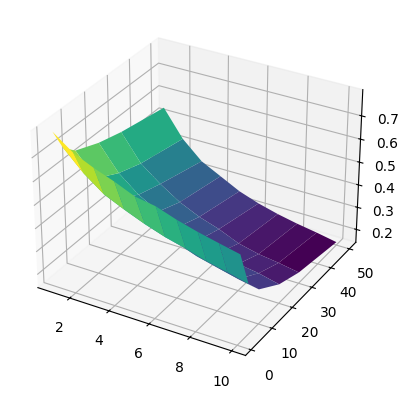

In [40]:
change_descriptor = pd.read_csv("statistic/change_descriptor.csv")
has_release = pd.read_csv("statistic/has_release.csv")
num_link = np.array(change_descriptor.columns[1:])
num_rn = np.array([1, 5, 10, 20, 30, 50])
X, Y = np.meshgrid(num_link, num_rn)

counter = np.zeros((len(num_rn), len(num_link)), dtype=np.float32)
for i in range(counter.shape[0]):
    for j in range(counter.shape[1]):   
        counter[i, j] = len(change_descriptor[change_descriptor[num_link[j]]>=num_rn[i]]) / len(has_release[has_release["num release"]>=num_rn[i]])
X = X.astype(np.float32)
Y = Y.astype(np.float32)
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_surface(X, Y, counter, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

<Axes: >

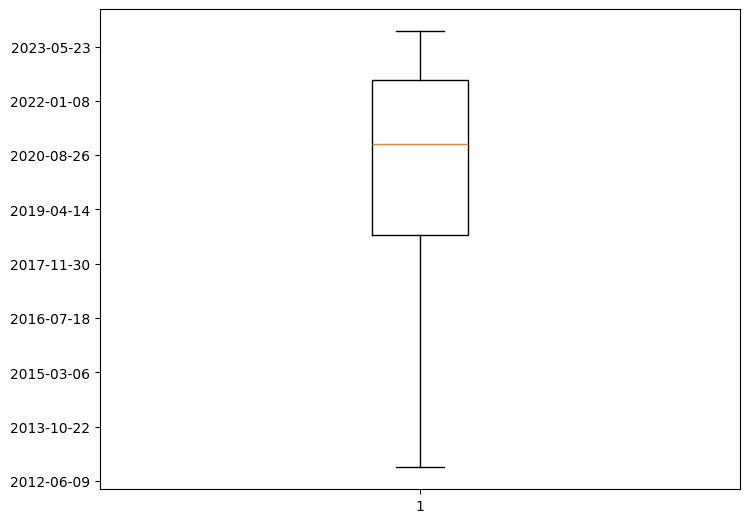

In [41]:

num_link = 1

def validate(rn, valid_link_num: int) -> bool:
    if pd.isna(rn):
        return False
    rn = str(rn)  
    pull_requests = re.findall(r"https:\/\/github.com\/[a-zA-Z0-9-]+\/[a-zA-Z0-9-]+\/pull\/[0-9]+", rn)
    issues = re.findall(r"https:\/\/github.com\/[a-zA-Z0-9-]+\/[a-zA-Z0-9-]+\/issues\/[0-9]+", rn)
    pr_issue = re.findall(r"\#[0-9]+\b", rn)  
    commits = re.findall(r"\b[0-9a-f]{7,40}\b", rn)
    return ((len(pull_requests) + len(commits) + len(issues) >= valid_link_num) or
            (len(pr_issue) + len(commits) >= valid_link_num))

repos = pd.read_csv("statistic/has_release.csv")
date = []
for repo in repos["Repo"]:
    release_info = pd.read_csv(f"statistic/release/{repo.replace('/', '_')}.csv")[["body", "created_at"]]
    release_time = pd.to_datetime(release_info["created_at"]).dt.to_pydatetime()
    for i in range(len(release_info)):
        if validate(release_info.loc[i, "body"], num_link):
            date.append(release_time[i])

date = date2num(date)
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.boxplot(date, 0, '')
axes.yaxis.set_major_formatter(lambda x, pos: num2date(x).date())
axes


<Axes: >

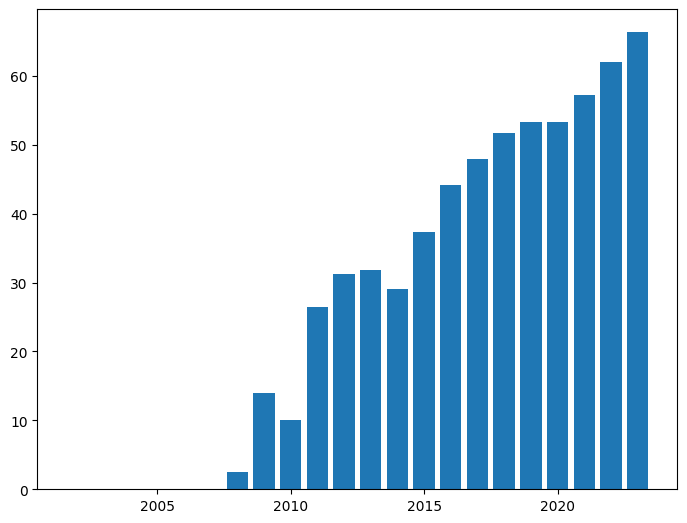

In [42]:
num_link = 1
def validate(rn, valid_link_num: int) -> bool:
    if pd.isna(rn):
        return False
    rn = str(rn)  
    pull_requests = re.findall(r"https:\/\/github.com\/[a-zA-Z0-9-]+\/[a-zA-Z0-9-]+\/pull\/[0-9]+", rn)
    issues = re.findall(r"https:\/\/github.com\/[a-zA-Z0-9-]+\/[a-zA-Z0-9-]+\/issues\/[0-9]+", rn)
    pr_issue = re.findall(r"\#[0-9]+\b", rn)  
    commits = re.findall(r"\b[0-9a-f]{7,40}\b", rn)
    return ((len(pull_requests) + len(commits) + len(issues) >= valid_link_num) or
            (len(pr_issue) + len(commits) >= valid_link_num))

repos = pd.read_csv("statistic/has_release.csv")
release_time = defaultdict(lambda: [0, 0])
for repo in repos["Repo"]:
    release_info = pd.read_csv(f"statistic/release/{repo.replace('/', '_')}.csv")[["body", "created_at"]]
    release_info["created_at"] = pd.to_datetime(release_info["created_at"])
    release_info["year"] = release_info["created_at"].dt.year
    for i in range(len(release_info)):
        release_time[release_info.loc[i, "year"]][0] += 1
        if validate(release_info.loc[i, "body"], num_link):
            release_time[release_info.loc[i, "year"]][1] += 1    

result = defaultdict()
for year in release_time:
    result[year] = round(release_time[year][1] / release_time[year][0] * 10000) / 100

fig = plt.figure()
axes = fig.add_axes([0 , 0, 1, 1])
axes.bar(result.keys(), result.values())
axes